In [2]:
# %matplotlib inline
import os

# Let's pick the desired backend
# os.environ['USE_TF'] = '1'
os.environ['USE_TORCH'] = '1'

import matplotlib.pyplot as plt

from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import numpy as np
import json
import cv2

import warnings
warnings.filterwarnings('ignore')

In [3]:
predictor = ocr_predictor(pretrained=True)
doc = DocumentFile.from_images(f"5.jpg")
result = predictor(doc)

json_export = result.export()
d = json_export
print(json_export)

{'pages': [{'page_idx': 0, 'dimensions': (576, 1280), 'orientation': {'value': None, 'confidence': None}, 'language': {'value': None, 'confidence': None}, 'blocks': [{'geometry': ((0.4609375, 0.0030381944444444198), (0.5458984375, 0.033420138888888895)), 'lines': [{'geometry': ((0.4609375, 0.0030381944444444198), (0.5458984375, 0.033420138888888895)), 'words': [{'value': 'SAP', 'confidence': 0.8630479574203491, 'geometry': ((0.4609375, 0.00737847222222221), (0.4814453125, 0.03125)), 'crop_orientation': {'value': 0, 'confidence': None}}, {'value': 'CODE:', 'confidence': 0.8589932918548584, 'geometry': ((0.478515625, 0.0030381944444444198), (0.51171875, 0.033420138888888895)), 'crop_orientation': {'value': 0, 'confidence': None}}, {'value': 'IMFCPOS', 'confidence': 0.6834436655044556, 'geometry': ((0.5078125, 0.0030381944444444198), (0.5458984375, 0.033420138888888895)), 'crop_orientation': {'value': 0, 'confidence': None}}]}], 'artefacts': []}, {'geometry': ((0.3828125, 0.27213541666666

In [5]:
image_path = "5.jpg"
image = cv2.imread(image_path)
orig_height, orig_width = image.shape[:2]

ocr_width, ocr_height = json_export['pages'][0]['dimensions']

width_ratio = orig_width / ocr_width
height_ratio = orig_height / ocr_height

# Convert relative bounding box to absolute bounding box in xyxy format
def relative_to_absolute_bbox(rel_bbox, width_ratio, height_ratio):
    x_min_rel, y_min_rel = rel_bbox[0]
    x_max_rel, y_max_rel = rel_bbox[1]
    x_min = int(x_min_rel * ocr_width * width_ratio)
    y_min = int(y_min_rel * ocr_height * height_ratio)
    x_max = int(x_max_rel * ocr_width * width_ratio)
    y_max = int(y_max_rel * ocr_height * height_ratio)
    return [x_min, y_min, x_max, y_max]

# Collect words and their bounding boxes
word_boxes = []
for page in json_export['pages']:
    for block in page['blocks']:
        for line in block['lines']:
            for word in line['words']:
                abs_bbox = relative_to_absolute_bbox(word['geometry'], width_ratio, height_ratio)
                word_boxes.append({"word": word['value'], "bounding_box": abs_bbox})

# Desired JSON format
output_json = word_boxes

# Write to JSON file
with open("output.json", "w") as f:
    json.dump(output_json, f, indent=4)

print(json.dumps(output_json, indent=4))

[
    {
        "word": "SAP",
        "bounding_box": [
            590,
            4,
            616,
            18
        ]
    },
    {
        "word": "CODE:",
        "bounding_box": [
            612,
            1,
            655,
            19
        ]
    },
    {
        "word": "IMFCPOS",
        "bounding_box": [
            650,
            1,
            698,
            19
        ]
    },
    {
        "word": "Amulspray",
        "bounding_box": [
            490,
            156,
            727,
            204
        ]
    },
    {
        "word": "SAP",
        "bounding_box": [
            856,
            167,
            885,
            186
        ]
    },
    {
        "word": "CODE",
        "bounding_box": [
            881,
            166,
            916,
            185
        ]
    },
    {
        "word": "IMFCPO3",
        "bounding_box": [
            918,
            166,
            966,
            185
        ]
    },
    {
        "wo

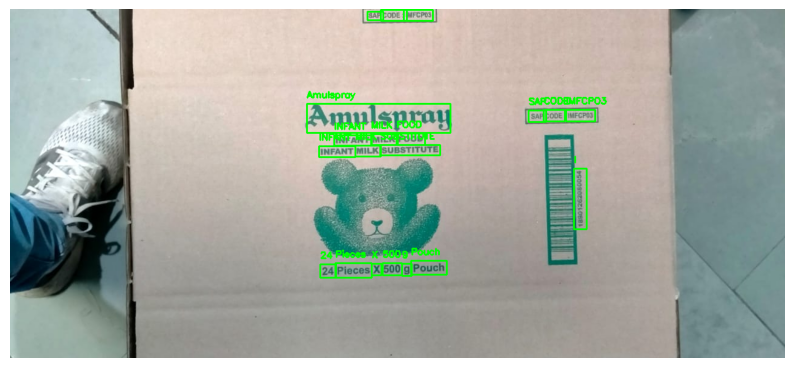

In [8]:
import cv2
import matplotlib.pyplot as plt

def draw_bounding_boxes(image_path, json_path):
    image = cv2.imread(image_path)

    with open(json_path, 'r') as f:
        bounding_boxes = json.load(f)
        
    for item in bounding_boxes:
        word = item['word']
        bbox = item['bounding_box']
        x_min, y_min, x_max, y_max = bbox

        # Draw the bounding box
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(image, word, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

image_path = "5.jpg"
json_path = "output.json"

# Call the function to draw bounding boxes
draw_bounding_boxes(image_path, json_path)

In [10]:
def inpaint_text(image_path, json_path, output_path):
    image = cv2.imread(image_path)
    with open(json_path, 'r') as f:
        bounding_boxes = json.load(f)

    
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Draw white rectangles on the mask where the bounding boxes are located
    for item in bounding_boxes:
        bbox = item['bounding_box']
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(mask, (x_min, y_min), (x_max, y_max), (255), thickness=cv2.FILLED)

    inpainted_image = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    # Save the inpainted image
    cv2.imwrite(output_path, inpainted_image)

# Example usage
image_path = "5.jpg"
json_path = "output.json"
output_path = "inpainted_img.jpg"
inpaint_text(image_path, json_path, output_path)

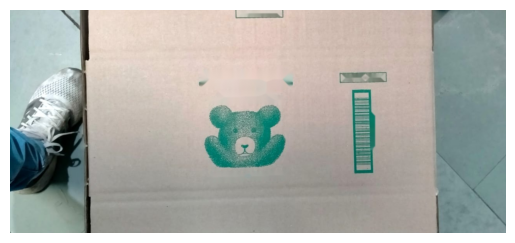

In [15]:
img = cv2.imread("inpainted_img.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()